In [37]:
import os, pickle
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import matplotlib.pyplot as plt

from neuralfingerprint import load_data, relu
from neuralfingerprint import build_conv_deep_net, build_convnet_fingerprint_fun
from neuralfingerprint import normalize_array, adam
from neuralfingerprint import build_batched_grad, degrees, build_standard_net
from neuralfingerprint.util import rmse
from neuralfingerprint.data_util import remove_duplicates

# Dataset

"Experimental and calculated hydration free energy of small molecules in water"

In [38]:
import pandas
SAMPL = pandas.read_csv("SAMPL.csv")

In [39]:
SAMPL

iupac                  smiles   expt    calc
0    4-methoxy-N,N-dimethyl-benzamide  CN(C)C(=O)c1ccc(cc1)OC -11.01  -9.625
1            methanesulfonyl chloride            CS(=O)(=O)Cl  -4.87  -6.219
2                   3-methylbut-1-ene                CC(C)C=C   1.83   2.452
3                     2-ethylpyrazine              CCc1cnccn1  -5.45  -5.809
4                         heptan-1-ol                CCCCCCCO  -4.21  -2.917
..                                ...                     ...    ...     ...
637                  methyl octanoate          CCCCCCCC(=O)OC  -2.04  -3.035
638                       pyrrolidine                 C1CCNC1  -5.48  -4.278
639             4-hydroxybenzaldehyde          c1cc(ccc1C=O)O  -8.83 -10.050
640                   1-chloroheptane               CCCCCCCCl   0.29   1.467
641                       1,4-dioxane                C1COCCO1  -5.06  -4.269

[642 rows x 4 columns]

# Параметры

In [40]:
task_params = {'N_train'     : 450,
               'N_valid'     : 92,
               'N_test'      : 100,
               'target_name' : 'expt',
               'data_file'   : 'SAMPL.csv'} 

num_epochs = 100
batch_size = 50
normalize = 1
dropout = 0
activation = relu

params = {'fp_length': 50,
            'fp_depth': 5,
            'init_scale':np.exp(-4),
            'learn_rate':np.exp(-7),
                    'b1':np.exp(-4),
                    'b2':np.exp(-4),
            'l2_penalty':np.exp(-5),
            'l1_penalty':np.exp(-4),
            'conv_width':10} 


conv_layer_sizes = [params['conv_width']] * params['fp_depth']
conv_arch_params = {'num_hidden_features' : conv_layer_sizes,
                    'fp_length' : params['fp_length'],
                    'normalize' : normalize,
                    'return_atom_activations':False}

all_radii = list(range(params['fp_depth'] + 1))

# Plotting parameters
num_figs_per_fp = 11
figsize = (100, 100)
highlight_color = (30.0/255.0, 100.0/255.0, 255.0/255.0)  # A nice light blue.



In [41]:
def parse_training_params(params):
    nn_train_params = {'num_epochs'  : num_epochs,
                       'batch_size'  : batch_size,
                       'learn_rate'  : params['learn_rate'],
                       'b1'          : params['b1'],
                       'b2'          : params['b2'],
                       'param_scale' : params['init_scale']}

    vanilla_net_params = {'layer_sizes':[params['fp_length']],  # Linear regression.
                          'normalize':normalize,
                          'L2_reg': params['l2_penalty'],
                          'L1_reg': params['l1_penalty'],
                          'activation_function':activation}
    return nn_train_params, vanilla_net_params

In [42]:
def train_nn(pred_fun, loss_fun, num_weights, train_smiles, train_raw_targets, train_params,
             validation_smiles=None, validation_raw_targets=None):
    """loss_fun has inputs (weights, smiles, targets)"""
    print("Total number of weights in the network:", num_weights)
    npr.seed(0)
    init_weights = npr.randn(num_weights) * train_params['param_scale']

    train_targets, undo_norm = normalize_array(train_raw_targets)
    training_curve = []
    def callback(weights, iter):
        if iter % 10 == 0:
            print("max of weights", np.max(np.abs(weights)))
            train_preds = undo_norm(pred_fun(weights, train_smiles))
            cur_loss = loss_fun(weights, train_smiles, train_targets)
            training_curve.append(cur_loss)
            print("Iteration", iter) 
            print("loss", cur_loss, "train RMSE", np.sqrt(np.mean((train_preds - train_raw_targets)**2)), end=' ')
            if validation_smiles is not None:
                validation_preds = undo_norm(pred_fun(weights, validation_smiles))
                print("Valid. RMSE", iter, ":", \
                    np.sqrt(np.mean((validation_preds - validation_raw_targets) ** 2)), end=' ')
                    
    grad_fun = grad(loss_fun)
    grad_fun_with_data = build_batched_grad(grad_fun, train_params['batch_size'],
                                            train_smiles, train_targets)

    num_iters = train_params['num_epochs'] * len(train_smiles) // train_params['batch_size']


    trained_weights = adam(grad_fun_with_data, init_weights, callback=callback,
                           num_iters=num_iters, step_size=train_params['learn_rate'],
                           b1=train_params['b1'], b2=train_params['b2'])

    def predict_func(new_smiles):
        """Returns to the original units that the raw targets were in."""
        return undo_norm(pred_fun(trained_weights, new_smiles))
    return predict_func, trained_weights, training_curve

In [43]:
def train_neural_fingerprint():
    print("Loading data...")
    traindata, valdata, testdata = load_data(task_params['data_file'],
                        (task_params['N_train'], task_params['N_valid'], task_params['N_test']),
                        input_name='smiles', target_name=task_params['target_name'])
    train_inputs, train_targets = traindata
    val_inputs, val_targets = valdata
    
    print("Regression on", task_params['N_train'], "training points.")
    def print_performance(pred_func):
        train_preds = pred_func(train_inputs)
        val_preds = pred_func(val_inputs)
        print("\nPerformance (RMSE) on " + task_params['target_name'] + ":")
        print("Train:", rmse(train_preds, train_targets))
        print("Test: ", rmse(val_preds,  val_targets))
        print("-" * 80)
        return rmse(val_preds,  val_targets)

    print("-" * 80)
    print("Mean predictor")
    y_train_mean = np.mean(train_targets)
    print_performance(lambda x : y_train_mean)

    print("Task params", params)
    nn_train_params, vanilla_net_params = parse_training_params(params)
    conv_arch_params['return_atom_activations'] = False

    print("Convnet fingerprints with neural net")
    loss_fun, pred_fun, conv_parser = \
        build_conv_deep_net(conv_arch_params, vanilla_net_params, params['l2_penalty'])
    num_weights = len(conv_parser)
    predict_func, trained_weights, conv_training_curve = \
         train_nn(pred_fun, loss_fun, num_weights, train_inputs, train_targets,
                 nn_train_params, validation_smiles=val_inputs, validation_raw_targets=val_targets)
    print_performance(predict_func)
    return trained_weights

In [44]:
def draw_molecule_with_highlights(filename, smiles, highlight_atoms):
    drawoptions = DrawingOptions()
    drawoptions.selectColor = highlight_color
    drawoptions.elemDict = {}   # Don't color nodes based on their element.
    drawoptions.bgColor=None

    mol = Chem.MolFromSmiles(smiles)
    fig = Draw.MolToMPL(mol, highlightAtoms=highlight_atoms, size=figsize, options=drawoptions,fitImage=False)

    fig.gca().set_axis_off()
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)

In [45]:
def construct_atom_neighbor_list(array_rep):
    atom_neighbour_list = []
    for degree in degrees:
        atom_neighbour_list += [list(neighbours) for neighbours in array_rep[('atom_neighbors', degree)]]
    return atom_neighbour_list

In [50]:
def plot(trained_weights):
    print("Loading training data...")
    traindata, valdata, testdata = load_data(task_params['data_file'],
                        (task_params['N_train'], task_params['N_valid'], task_params['N_test']),
                        input_name='smiles', target_name=task_params['target_name'])
    train_smiles, train_targets = traindata

    print("Convnet fingerprints with neural net")
    conv_arch_params['return_atom_activations'] = True
    output_layer_fun, parser, compute_atom_activations = \
       build_convnet_fingerprint_fun(**conv_arch_params)
    atom_activations, array_rep = compute_atom_activations(trained_weights, train_smiles)

#     if not os.path.exists('figures_SAMPL'): os.makedirs('figures_SAMPL')
    if not os.path.exists('figures_SAMPL_jpg'): os.makedirs('figures_SAMPL_jpg')
#     os.makedirs('figures_SAMPL_jpg')

    parent_molecule_dict = {}
    for mol_ix, atom_ixs in enumerate(array_rep['atom_list']):
        for atom_ix in atom_ixs:
            parent_molecule_dict[atom_ix] = mol_ix

    atom_neighbor_list = construct_atom_neighbor_list(array_rep)

    def get_neighborhood_ixs(array_rep, cur_atom_ix, radius):
        # Recursive function to get indices of all atoms in a certain radius.
        if radius == 0:
            return set([cur_atom_ix])
        else:
            cur_set = set([cur_atom_ix])
            for n_ix in atom_neighbor_list[cur_atom_ix]:
                cur_set.update(get_neighborhood_ixs(array_rep, n_ix, radius-1))
            return cur_set

    # Recreate trained network.
    nn_train_params, vanilla_net_params = parse_training_params(params)
    conv_arch_params['return_atom_activations'] = False
    _, _, combined_parser = \
        build_conv_deep_net(conv_arch_params, vanilla_net_params, params['l2_penalty'])

    net_loss_fun, net_pred_fun, net_parser = build_standard_net(**vanilla_net_params)
    net_weights = combined_parser.get(trained_weights, 'net weights')
    last_layer_weights = net_parser.get(net_weights, ('weights', 0))

    ###
    fingerprint_list = []
    ###
    
    for fp_ix in range(params['fp_length']):
        
        fingerprint_list.append((last_layer_weights[fp_ix][0], fp_ix))
        
        print("FP {0} has linear regression coefficient {1}".format(fp_ix, last_layer_weights[fp_ix][0]))
        combined_list = []
        for radius in all_radii:
            fp_activations = atom_activations[radius][:, fp_ix]
            combined_list += [(fp_activation, atom_ix, radius) for atom_ix, fp_activation in enumerate(fp_activations)]

        unique_list = remove_duplicates(combined_list, key_lambda=lambda x: x[0])
        combined_list = sorted(unique_list, key=lambda x: -x[0])
        
        for fig_ix in range(num_figs_per_fp):
            # Find the most-activating atoms for this fingerprint index, across all molecules and depths.
            activation, most_active_atom_ix, cur_radius = combined_list[fig_ix]
            most_activating_mol_ix = parent_molecule_dict[most_active_atom_ix]
            highlight_list_our_ixs = get_neighborhood_ixs(array_rep, most_active_atom_ix, cur_radius)
            highlight_list_rdkit = [array_rep['rdkit_ix'][our_ix] for our_ix in highlight_list_our_ixs]
            
            print("radius:", cur_radius, "atom list:", highlight_list_rdkit, "activation", activation)
            draw_molecule_with_highlights(
#                 "figures_SAMPL/fp_{0}_highlight_{1}.pdf".format(fp_ix, fig_ix),
                "figures_SAMPL_jpg/fp_{0}_highlight_{1}.jpg".format(fp_ix + 10, fig_ix + 10),
                train_smiles[most_activating_mol_ix],
                highlight_atoms=highlight_list_rdkit)
    
    ###
    fingerprint_list.sort(reverse=True)            
    with open('FP_out.txt', 'w') as f3:
        for line in fingerprint_list:
            f3.write('FP_' + str(line[1]) + ': ' + str(line[0]) + '\n')

# Training

In [47]:
 # Training.  Only need to run this part if we haven't yet saved results.pkl
trained_network_weights = train_neural_fingerprint()

Loading data...
Regression on 450 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on expt:
Train: 3.970263339277368
Test:  3.3293024704125993
--------------------------------------------------------------------------------
Task params {'fp_length': 50, 'fp_depth': 5, 'init_scale': 0.01831563888873418, 'learn_rate': 0.0009118819655545162, 'b1': 0.01831563888873418, 'b2': 0.01831563888873418, 'l2_penalty': 0.006737946999085467, 'l1_penalty': 0.01831563888873418, 'conv_width': 10}
Convnet fingerprints with neural net
Total number of weights in the network: 14941
max of weights 0.06962983567500523
Iteration 0
loss 1.011206329313244 train RMSE 3.9919903997141035 Valid. RMSE 0 : 3.345402584883726 max of weights 0.06727325016010127
Iteration 10
loss 0.9802209445228337 train RMSE 3.930351983713768 Valid. RMSE 10 : 3.37930303496502 max of weights 0.075700328881278
Iteration 20
loss 0.982761249772689 train RMSE 

loss 0.14167262263092922 train RMSE 1.4871464637707874 Valid. RMSE 540 : 1.5953380568102395 max of weights 0.4552684889279586
Iteration 550
loss 0.14372274976261948 train RMSE 1.4979686220694788 Valid. RMSE 550 : 1.7146308717750907 max of weights 0.4579253408535848
Iteration 560
loss 0.1506525037775193 train RMSE 1.5339799910875604 Valid. RMSE 560 : 1.8151713424721188 max of weights 0.4632820673230411
Iteration 570
loss 0.13489533404953244 train RMSE 1.4507179493919693 Valid. RMSE 570 : 1.5815220597397461 max of weights 0.46825122957028986
Iteration 580
loss 0.13388359691992455 train RMSE 1.4451996489568557 Valid. RMSE 580 : 1.592668570407946 max of weights 0.47271858086915647
Iteration 590
loss 0.14069291873573897 train RMSE 1.4818337635047714 Valid. RMSE 590 : 1.7204395331217108 max of weights 0.4795915746978042
Iteration 600
loss 0.1251090433642867 train RMSE 1.3964195711141516 Valid. RMSE 600 : 1.4768417806581684 max of weights 0.48301671171326144
Iteration 610
loss 0.1192849608546

# Запись результатов

In [48]:
with open('results_SAMPL.pkl', 'wb') as f:
    pickle.dump(trained_network_weights, f)

# Plot (trained_weights)

In [51]:
# Plotting.
with open('results_SAMPL.pkl', 'rb') as f:
    trained_weights = pickle.load(f)
plot(trained_weights)

Loading training data...
Convnet fingerprints with neural net
FP 0 has linear regression coefficient 0.06014475220210153
radius: 0 atom list: [1] activation 0.029496192333686333
radius: 0 atom list: [0] activation 0.0294269789800067
radius: 0 atom list: [6] activation 0.02680050875687051
radius: 0 atom list: [0] activation 0.026706076672493462
radius: 2 atom list: [0, 1] activation 0.02660329978558242
radius: 4 atom list: [0, 2, 1] activation 0.026490197817854458
radius: 4 atom list: [1, 2, 0, 3] activation 0.02648686348420385
radius: 4 atom list: [0, 4, 1, 2, 3] activation 0.02648565394132002
radius: 4 atom list: [1, 2, 3, 0, 4] activation 0.02647736623241671
radius: 4 atom list: [1, 0, 2] activation 0.02647635465910989
radius: 4 atom list: [1, 2, 0, 3] activation 0.02647571338121453
FP 1 has linear regression coefficient -0.11473676058037931
radius: 5 atom list: [1, 2, 3, 4, 0, 5, 6, 7, 8, 9, 10, 11] activation 0.13789219094151403
radius: 5 atom list: [6, 7, 8, 9, 10, 11, 1, 2, 3, 4,

radius: 2 atom list: [8, 9, 10, 1, 2, 3, 4, 5] activation 0.045439182847580036
FP 10 has linear regression coefficient -0.11731534833165555
radius: 2 atom list: [3, 2, 8, 4] activation 0.05521666098575467
radius: 2 atom list: [7, 2, 3, 4] activation 0.054992916209728016
radius: 2 atom list: [1, 2, 3, 4, 0, 8, 9, 10] activation 0.054089795233166996
radius: 2 atom list: [5, 7, 3, 4] activation 0.05395645377553658
radius: 2 atom list: [6, 5, 3, 4] activation 0.053922259511903374
radius: 2 atom list: [1, 6, 2, 3] activation 0.05375036283218762
radius: 2 atom list: [1, 9, 2, 0] activation 0.05368191957592576
radius: 2 atom list: [2, 5, 9, 4] activation 0.053017289477296864
radius: 2 atom list: [3, 1, 4, 6, 7, 5] activation 0.052943155393779966
radius: 2 atom list: [7, 6, 3] activation 0.052499466301671585
radius: 2 atom list: [7, 6, 2, 5, 0, 4] activation 0.052366878165391685
FP 11 has linear regression coefficient -0.12049389383033905
radius: 4 atom list: [1, 2, 3, 4, 0, 5, 6, 7, 8, 9, 10,

radius: 4 atom list: [0, 1] activation 0.0337536181526275
radius: 4 atom list: [1, 0] activation 0.033727250852343155
radius: 4 atom list: [1, 0] activation 0.033727018463825746
radius: 4 atom list: [0, 1] activation 0.03367950129608387
radius: 4 atom list: [0, 1] activation 0.03367899919055219
radius: 4 atom list: [0, 1] activation 0.0335519178973907
radius: 4 atom list: [1, 0, 2] activation 0.03351262895590988
FP 21 has linear regression coefficient -0.12007481432766516
radius: 3 atom list: [1, 2, 3, 4, 0, 5, 7, 8, 9, 10, 11] activation 0.054966933746098935
radius: 3 atom list: [6, 7, 1, 2, 3, 9, 4, 8, 0, 5] activation 0.05488452100592646
radius: 3 atom list: [6, 7, 8, 9, 10, 1, 2, 3, 4, 5] activation 0.05488079184087387
radius: 3 atom list: [6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 0] activation 0.05486154498566835
radius: 3 atom list: [6, 7, 1, 2, 3, 8, 9, 4, 0, 5] activation 0.05478081194947683
radius: 3 atom list: [1, 2, 3, 4, 0, 8, 9, 10, 11] activation 0.05468189860285877
radius: 3 atom 

radius: 3 atom list: [1, 0] activation 0.027932721654850567
radius: 3 atom list: [1, 0] activation 0.027931637841485894
radius: 3 atom list: [0, 1] activation 0.027908707748330815
radius: 3 atom list: [0, 1] activation 0.027906213184361692
radius: 3 atom list: [0, 1, 2] activation 0.02786662805498281
radius: 3 atom list: [1, 0, 2] activation 0.027828876427093117
FP 31 has linear regression coefficient 0.07196204877092699
radius: 5 atom list: [1, 0, 2] activation 0.04348103406415941
radius: 5 atom list: [0, 4, 1, 2, 3] activation 0.04253350067616818
radius: 5 atom list: [0, 1] activation 0.04224386555236416
radius: 5 atom list: [0, 4, 1, 2, 3] activation 0.04201948858835548
radius: 5 atom list: [1, 2, 0, 3] activation 0.04187902644215027
radius: 5 atom list: [1, 0, 2] activation 0.04147436607429712
radius: 5 atom list: [1, 0, 2] activation 0.041397126492553865
radius: 5 atom list: [0, 2, 1] activation 0.0413341851054193
radius: 5 atom list: [0, 2, 1] activation 0.04132667151068424
radiu

radius: 4 atom list: [1, 2, 3, 4, 0, 5, 7, 8, 9, 10, 11] activation 0.10935470554568053
radius: 4 atom list: [6, 7, 8, 9, 10, 1, 2, 3, 4, 5, 0] activation 0.10903493763051508
radius: 4 atom list: [6, 7, 1, 2, 3, 8, 9, 4, 0, 5] activation 0.10841774694968652
radius: 4 atom list: [6, 7, 1, 2, 9, 4, 3, 8, 0, 5] activation 0.1082707418169966
radius: 4 atom list: [0, 3, 6, 1, 4, 7, 2, 5, 8] activation 0.10639755446734797
radius: 4 atom list: [6, 7, 8, 9, 10, 11, 1, 2, 3, 4, 5, 0] activation 0.10512566586483879
radius: 4 atom list: [0, 1, 3, 4, 7, 6, 2, 5, 8] activation 0.10396909632348234
radius: 4 atom list: [1, 4, 7, 0, 3, 6, 2, 5, 8] activation 0.10241759158524374
radius: 4 atom list: [7, 1, 2, 5, 3, 6, 8, 0, 4] activation 0.1020734857742541
FP 42 has linear regression coefficient -0.10691296753042995
radius: 1 atom list: [8, 17, 18] activation 0.04296051902866203
radius: 1 atom list: [7, 5, 6, 4] activation 0.04089849090258251
radius: 1 atom list: [2, 3, 4] activation 0.0400528736860304

# Визуализация подструктур, активирующих биты фингерпринта

In [52]:
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import warnings

warnings.filterwarnings('ignore')

In [53]:
class MolDataset(Dataset):
    def __init__(self, path_to_dataset):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return image
    
    def __len__(self):
        return len(self.photo_names)

In [54]:
def visualize(each_eleven):
    fig = plt.figure(figsize=(16, 5))
    columns = 6
    rows = 2
    title = 'Fingerprint_' + str(each_eleven)
    fig.suptitle(title, fontsize=16)

    ax = []
    for i in range(11):
        
        img = dataset[(i) + each_eleven*11]
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(img)
        plt.axis('off') 

    plt.tight_layout()

In [55]:
dataset = MolDataset("figures_SAMPL_jpg")

In [56]:
len(dataset)

550

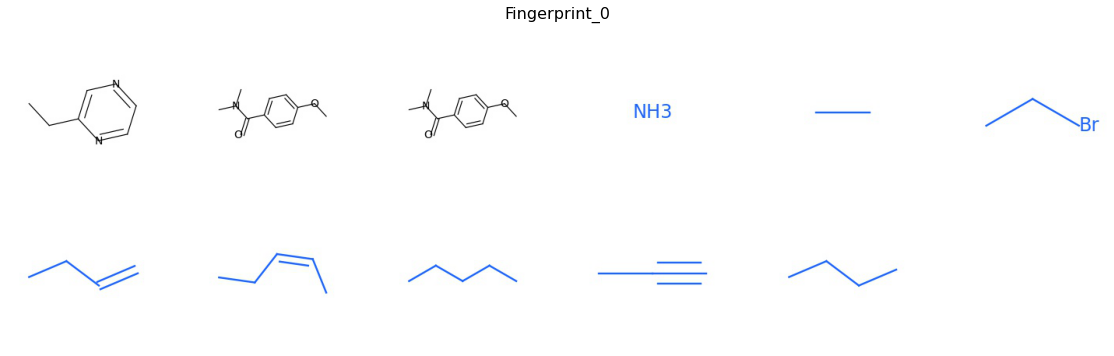

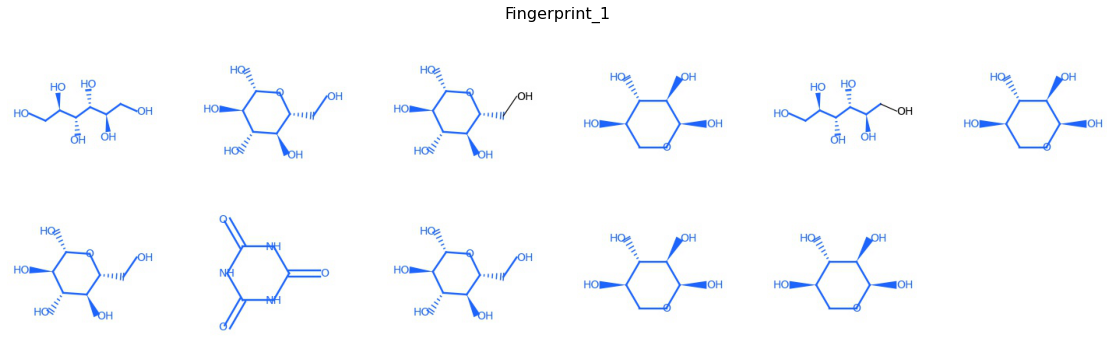

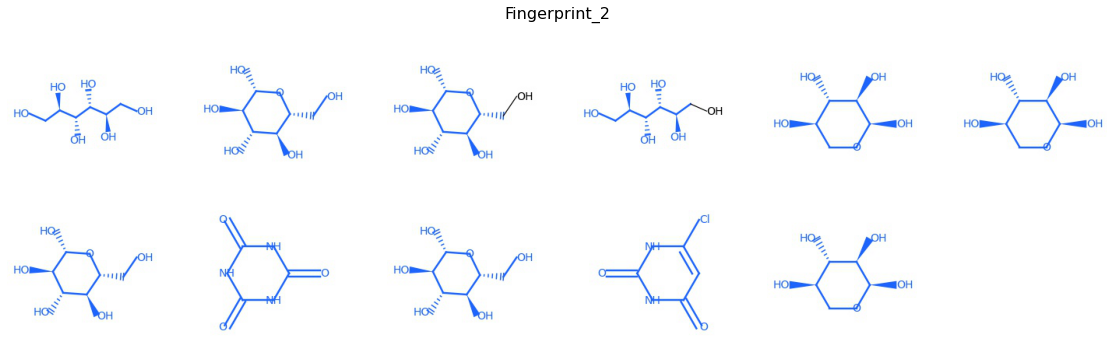

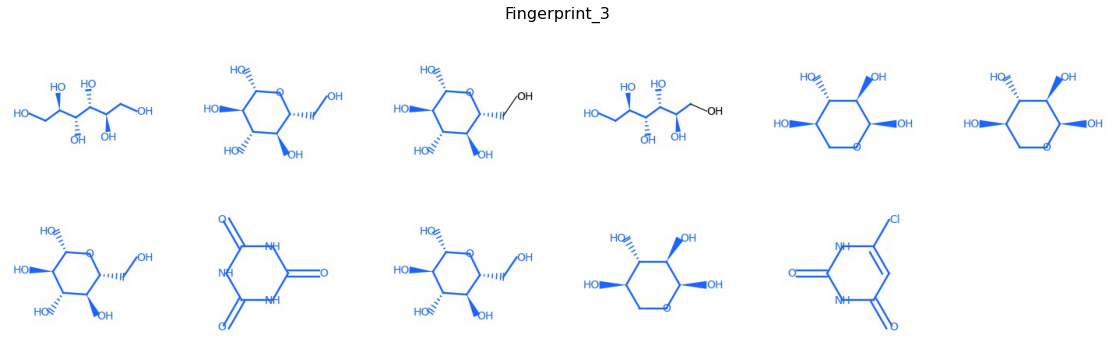

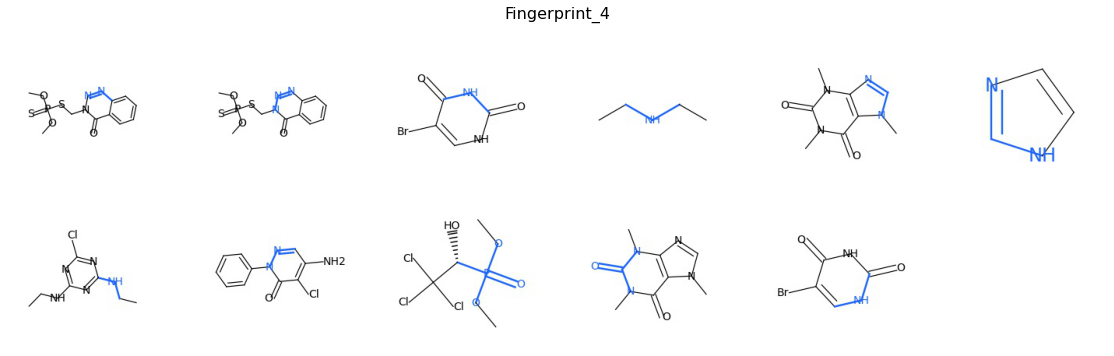

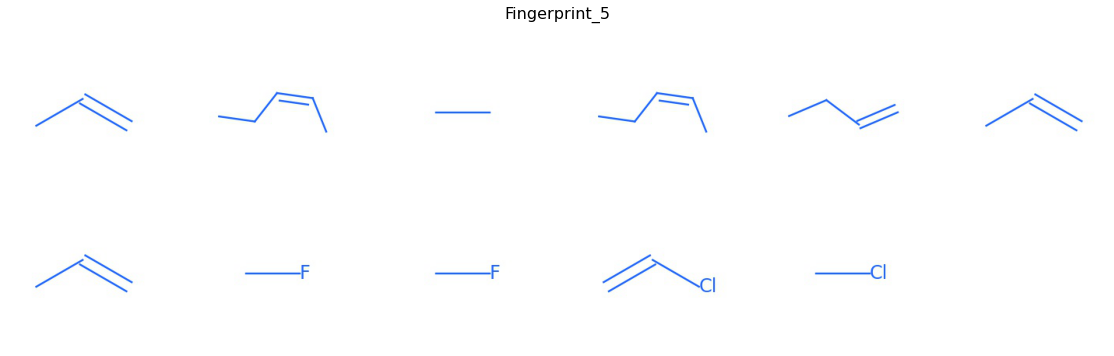

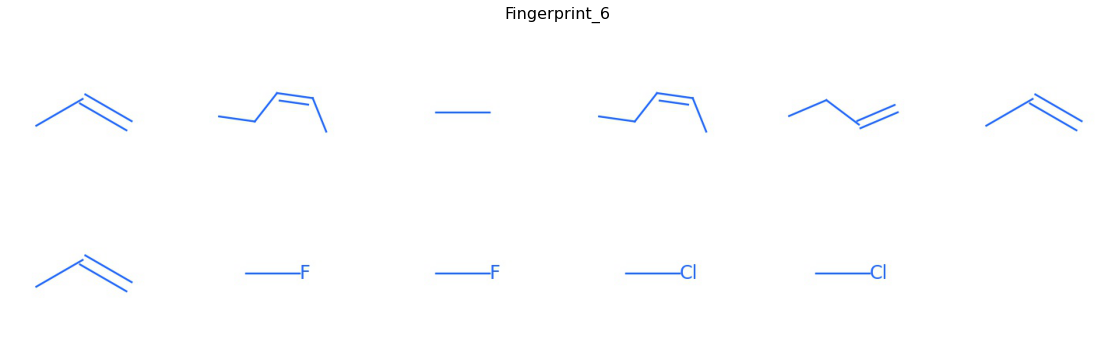

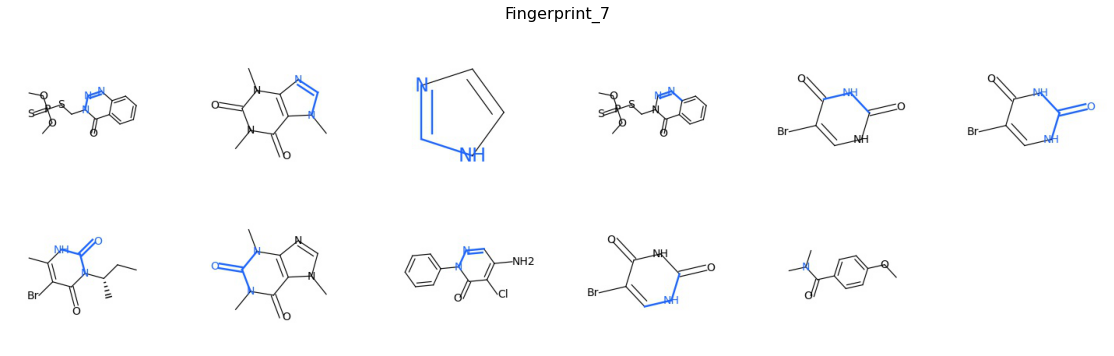

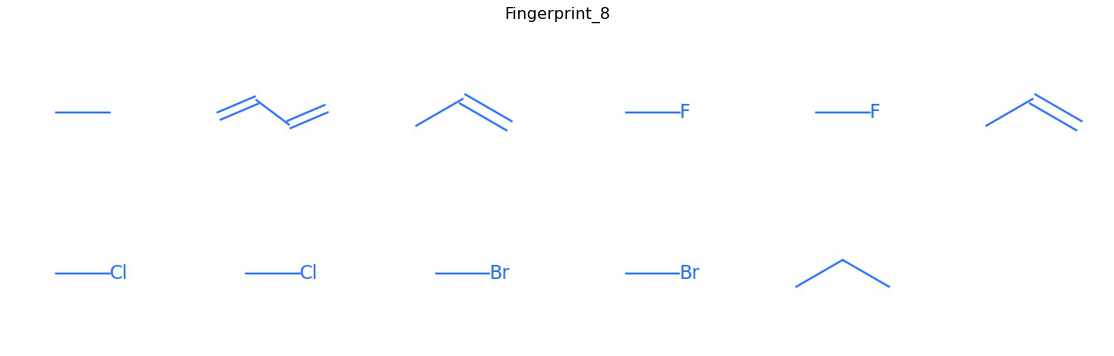

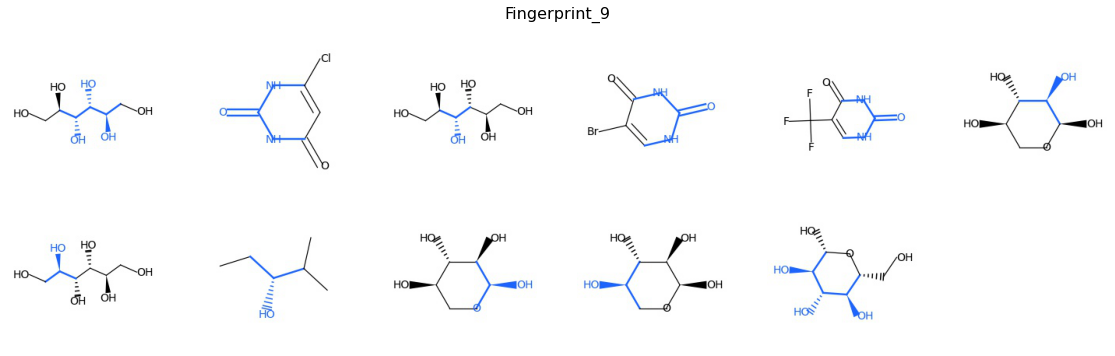

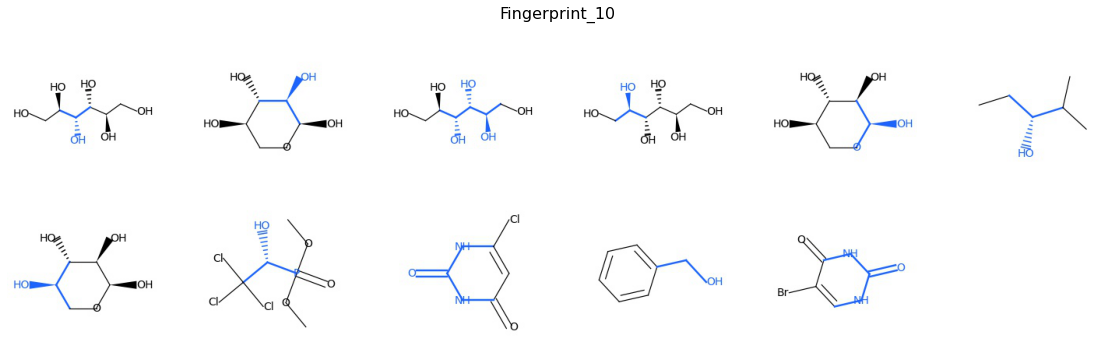

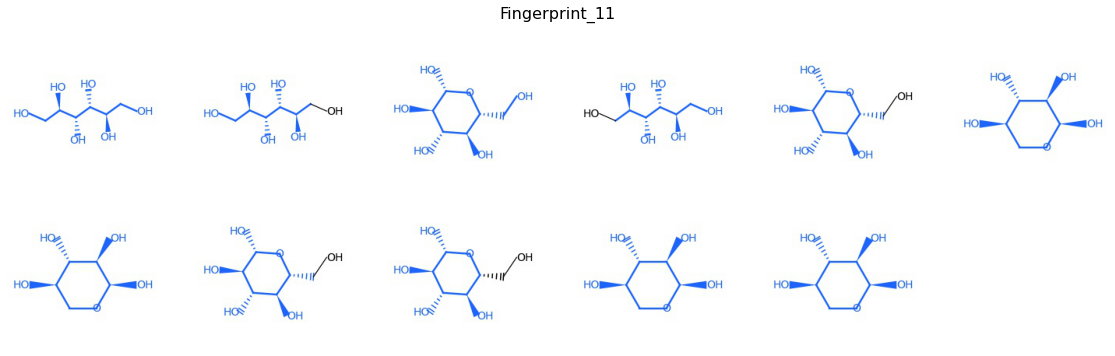

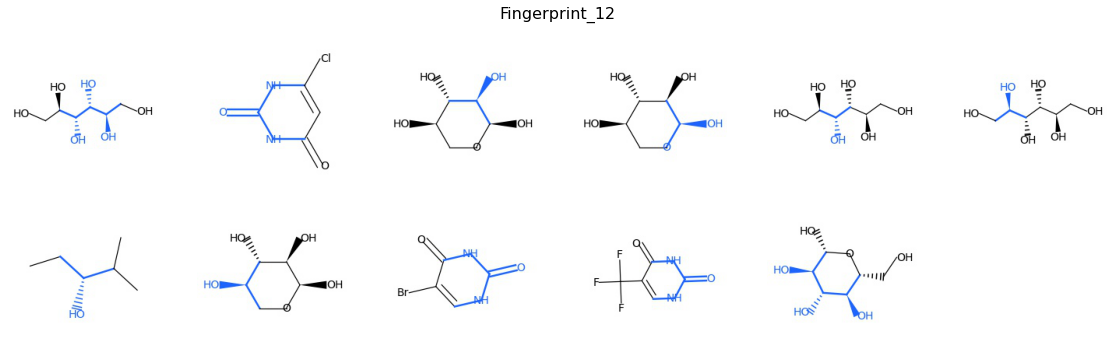

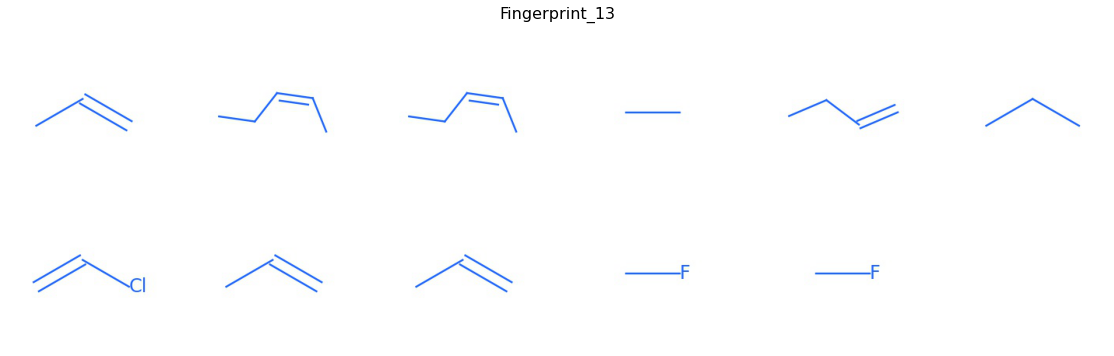

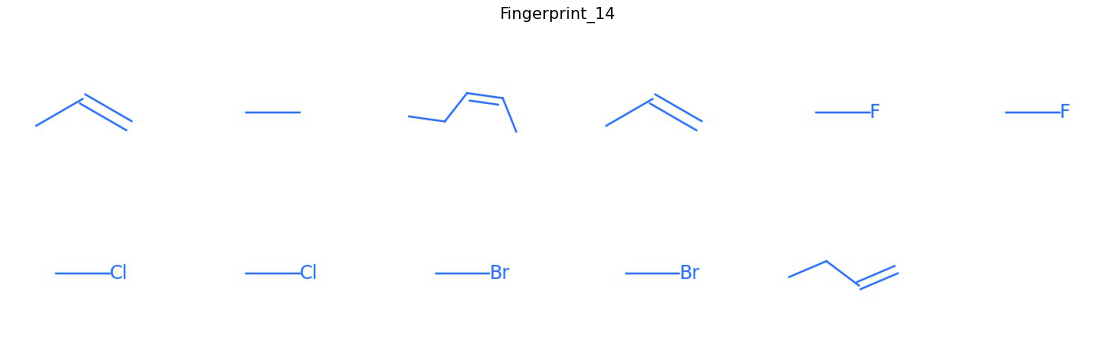

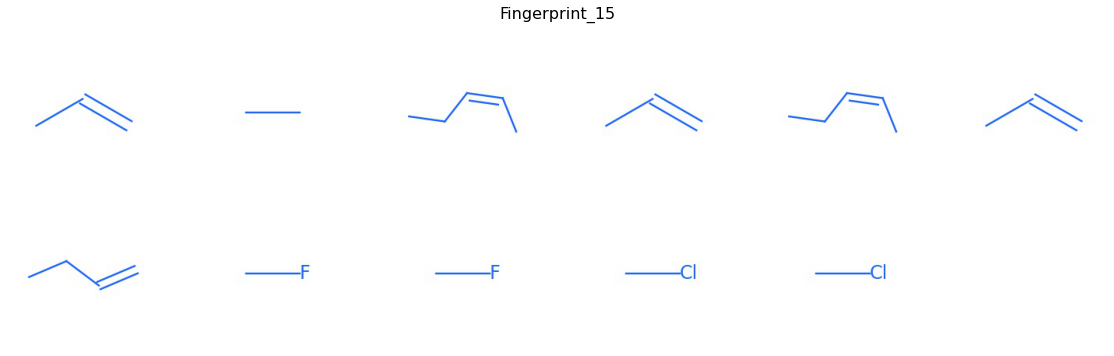

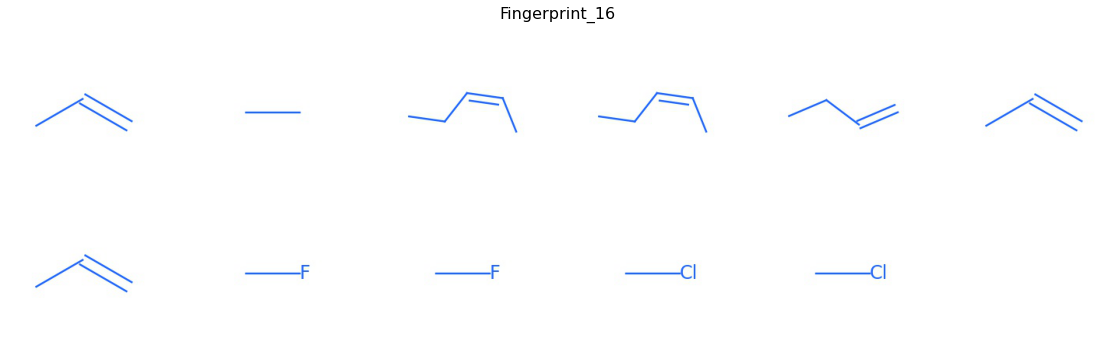

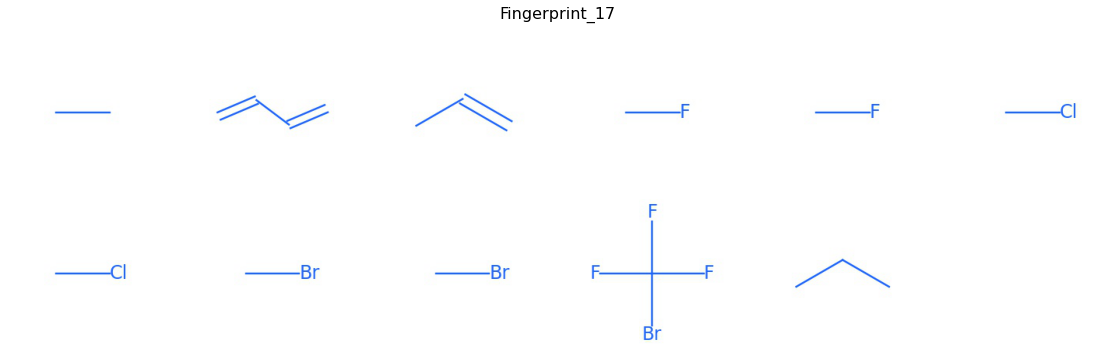

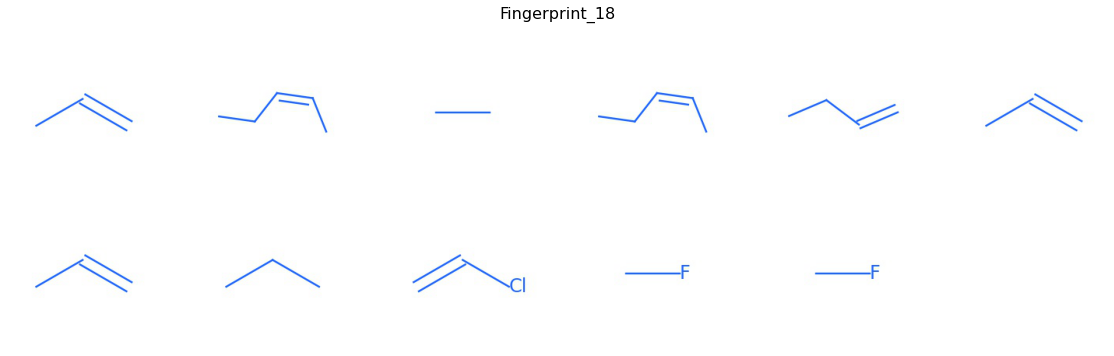

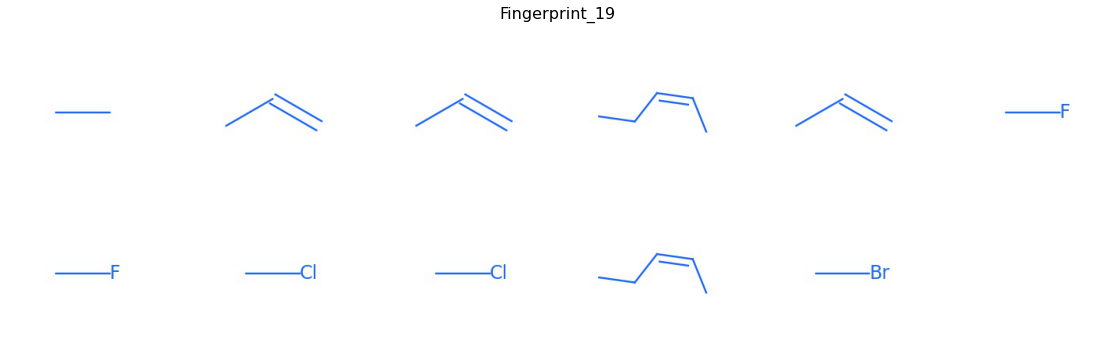

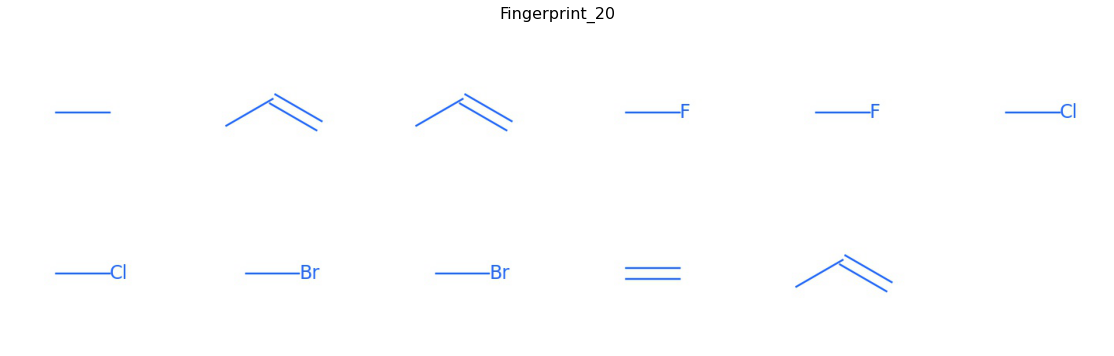

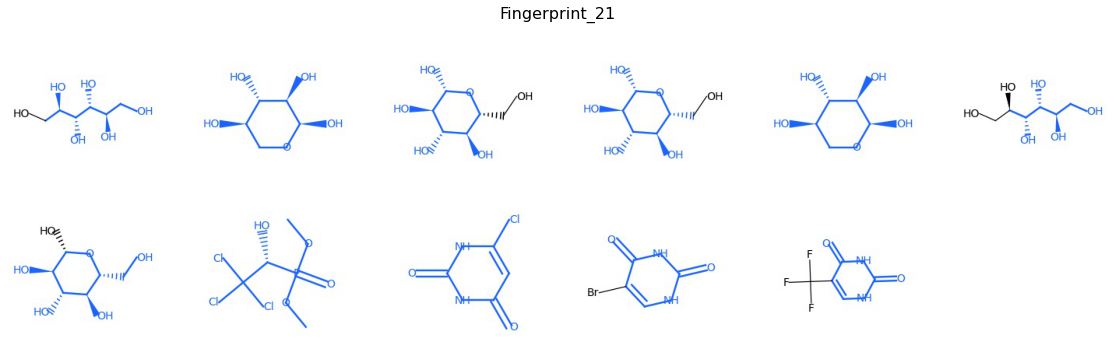

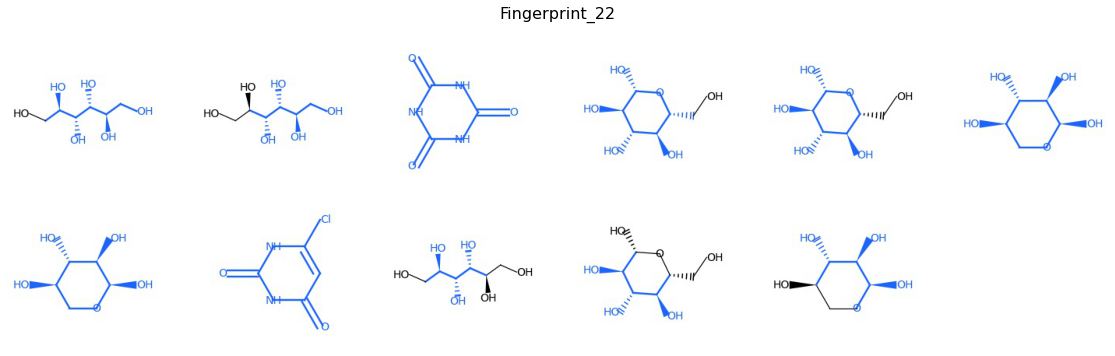

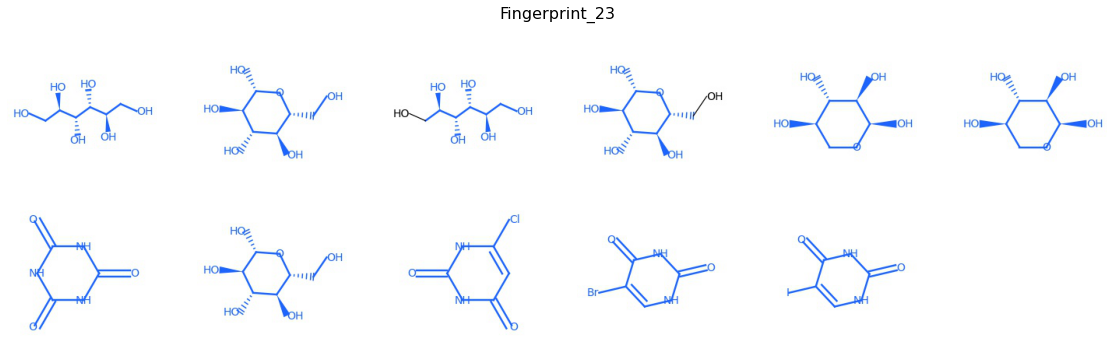

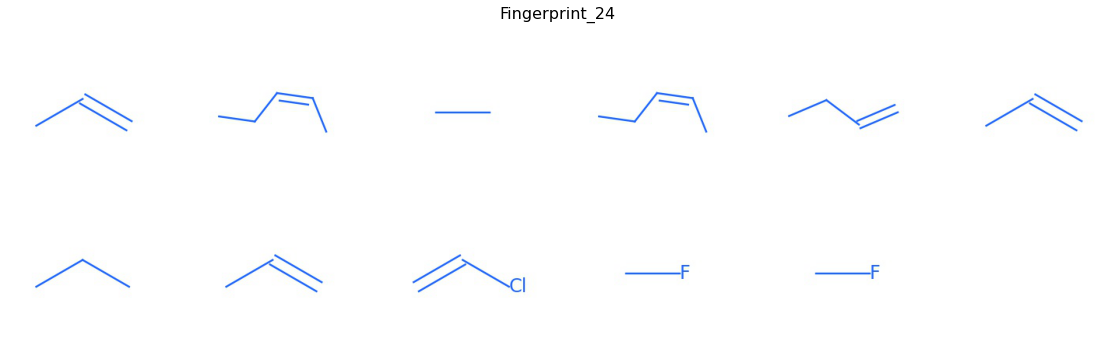

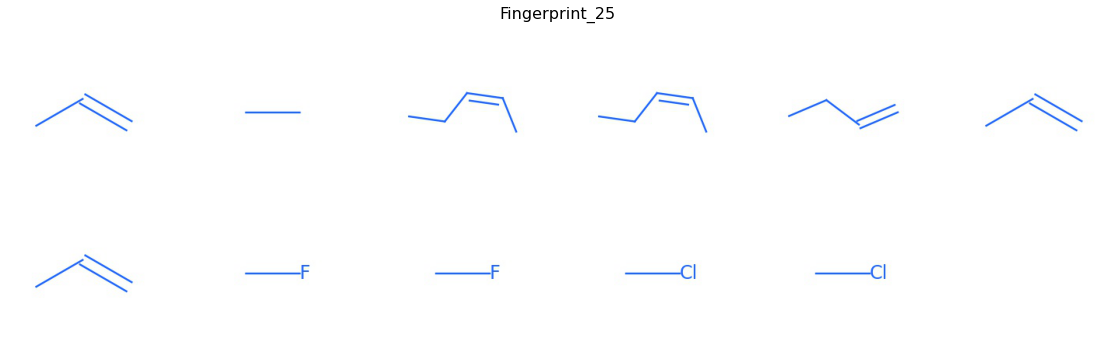

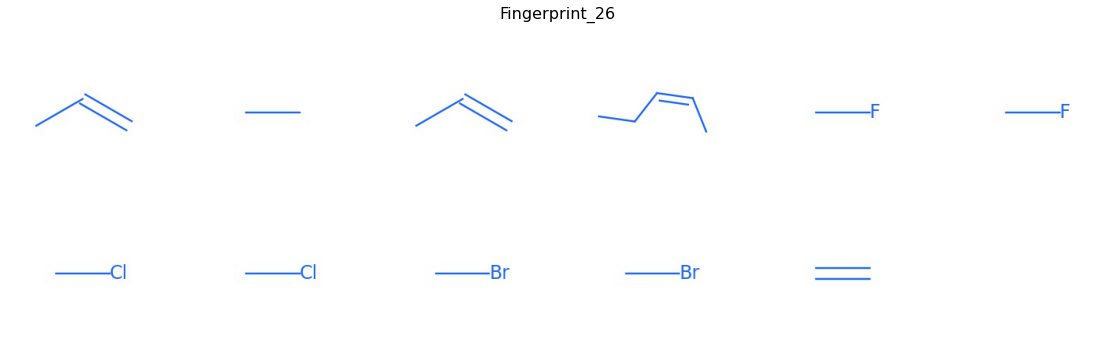

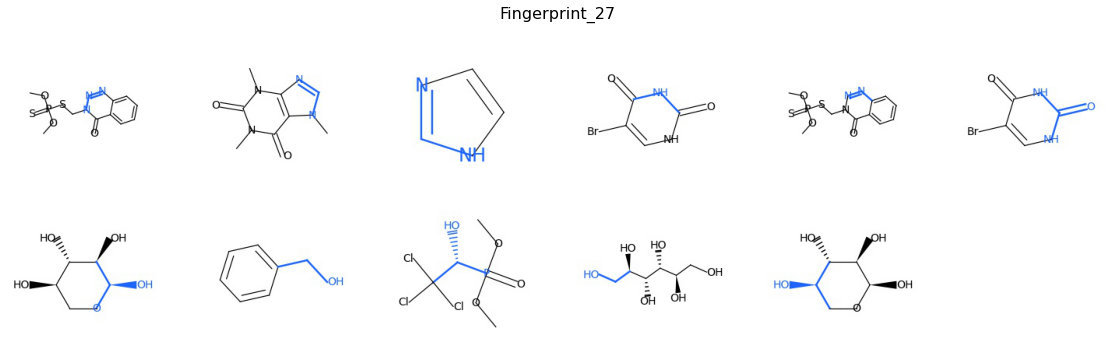

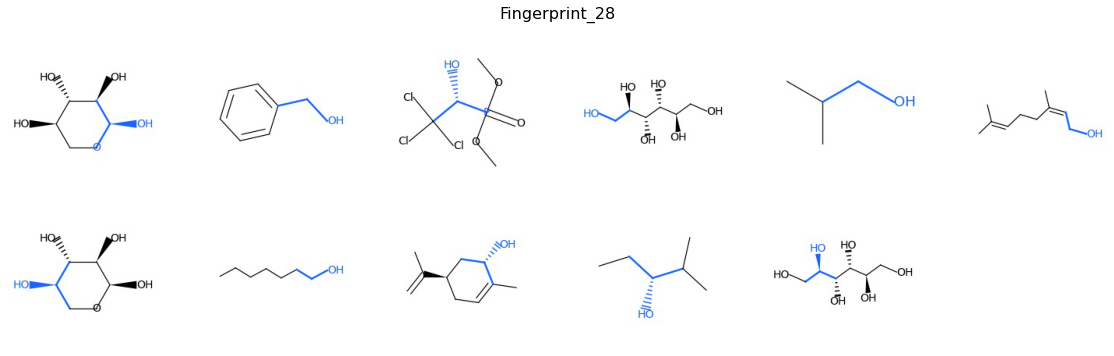

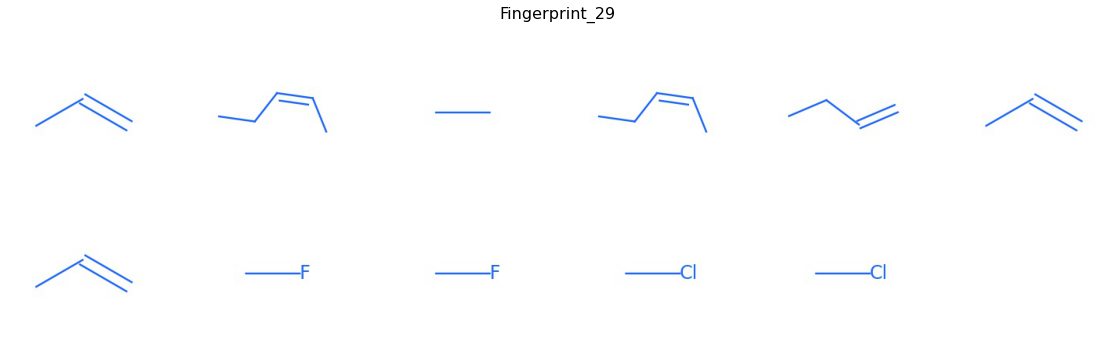

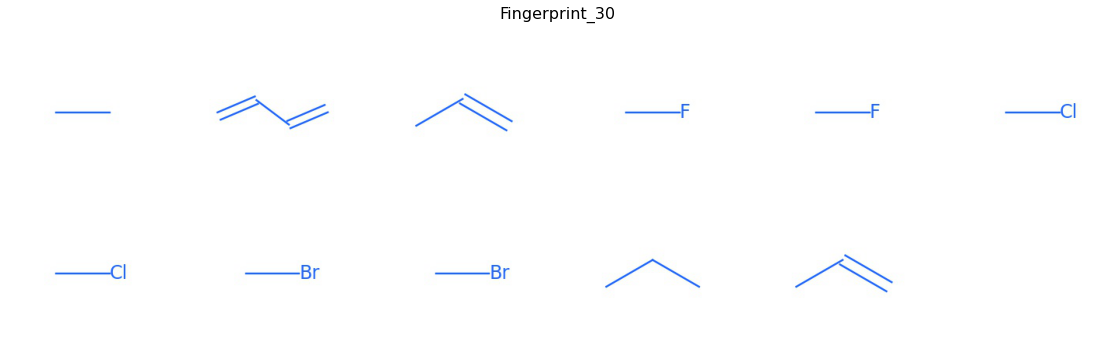

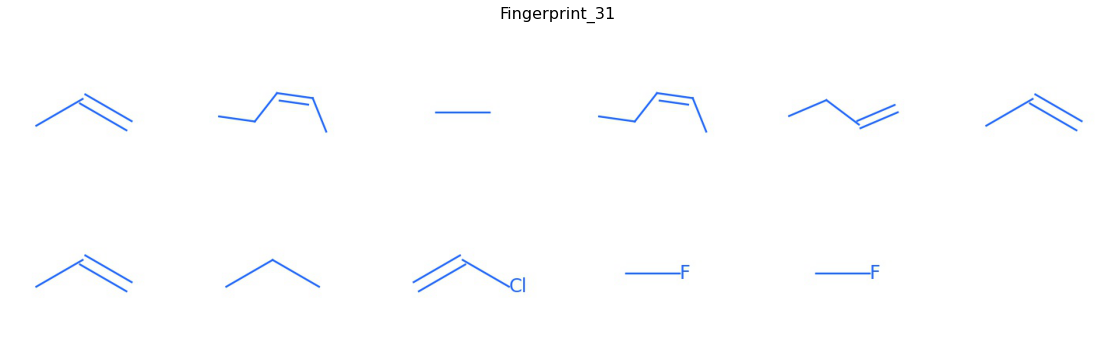

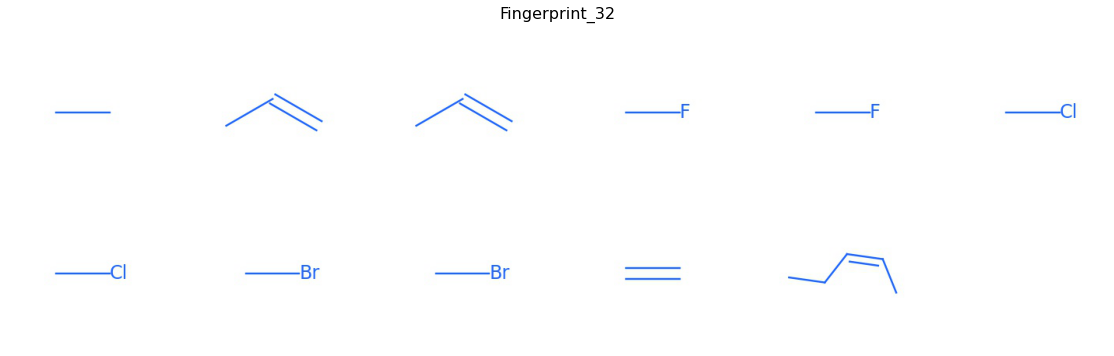

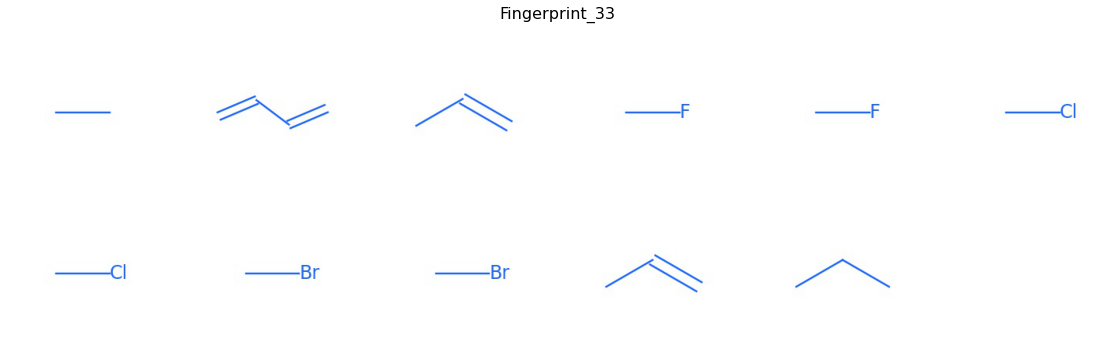

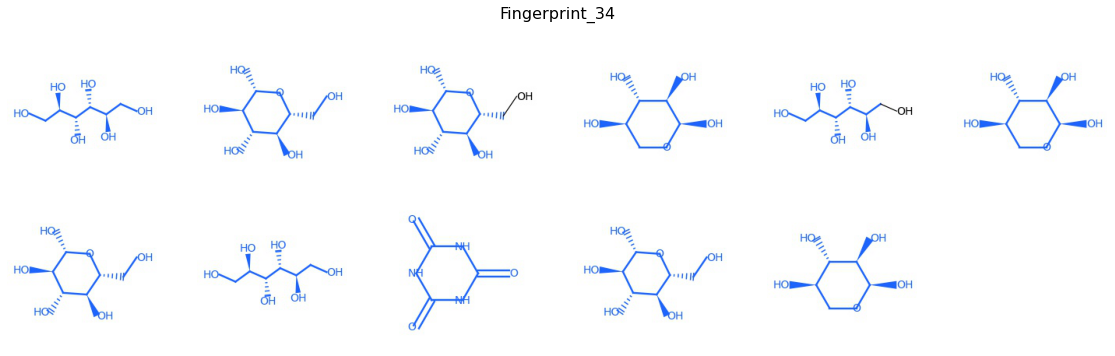

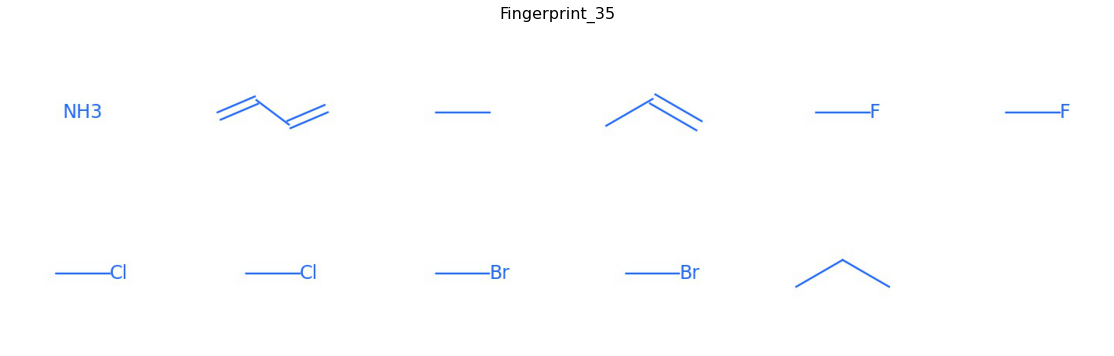

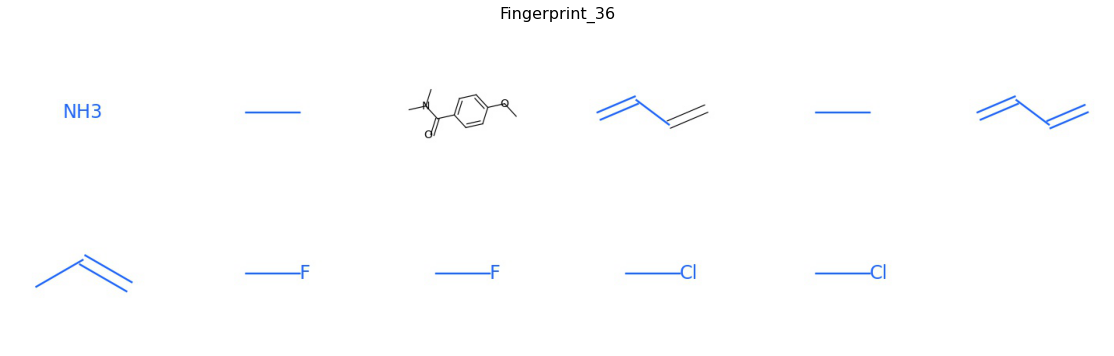

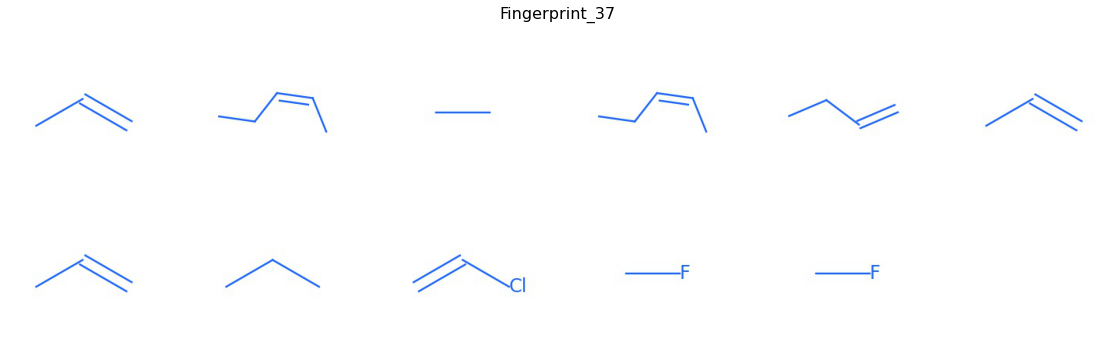

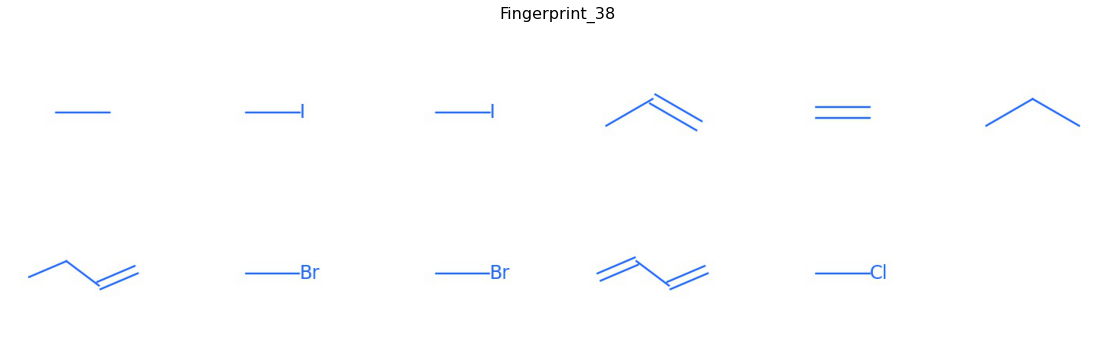

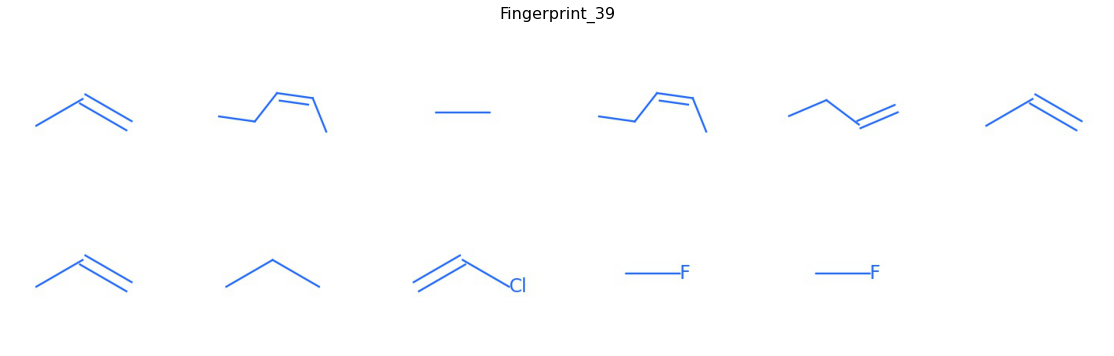

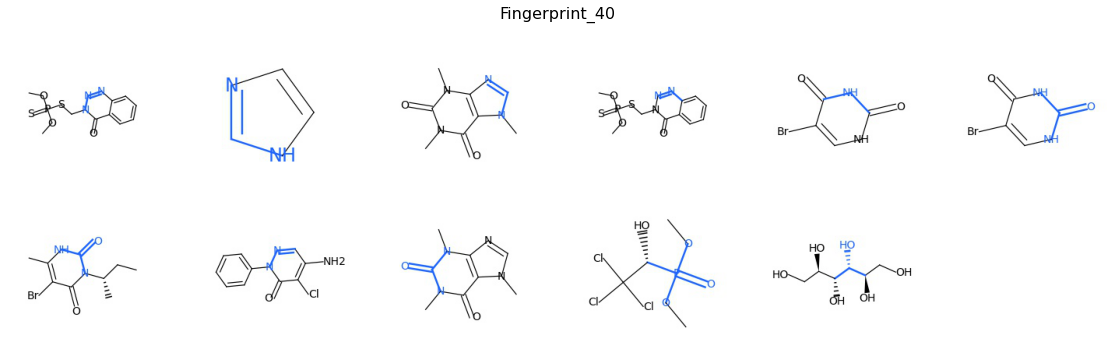

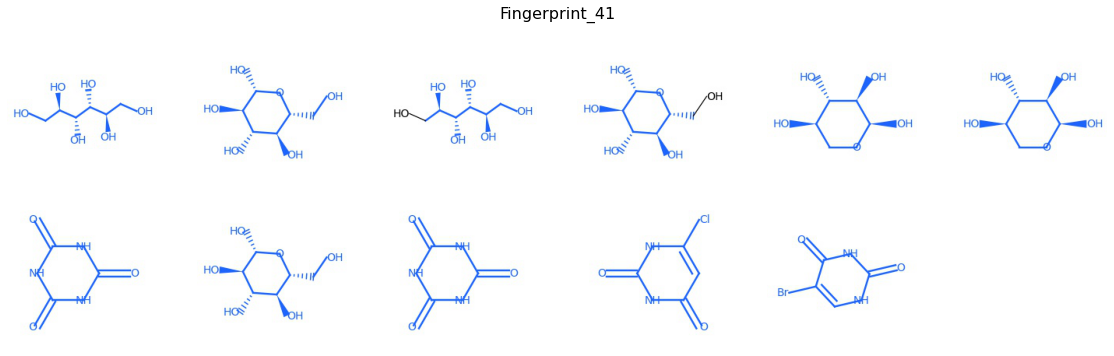

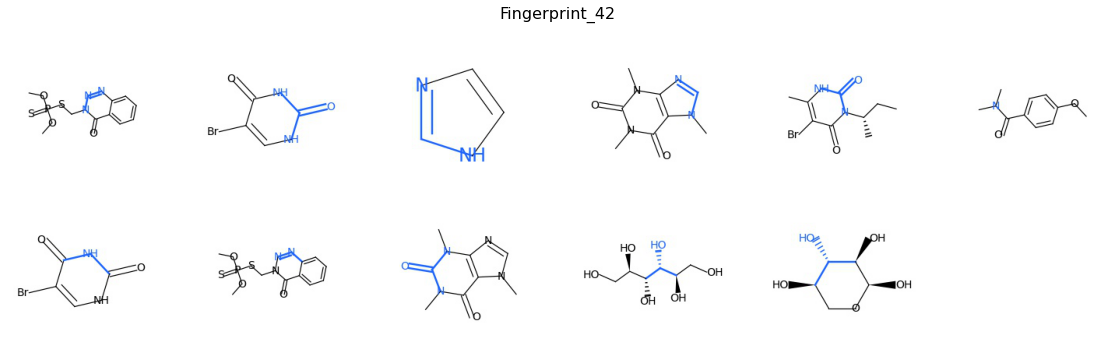

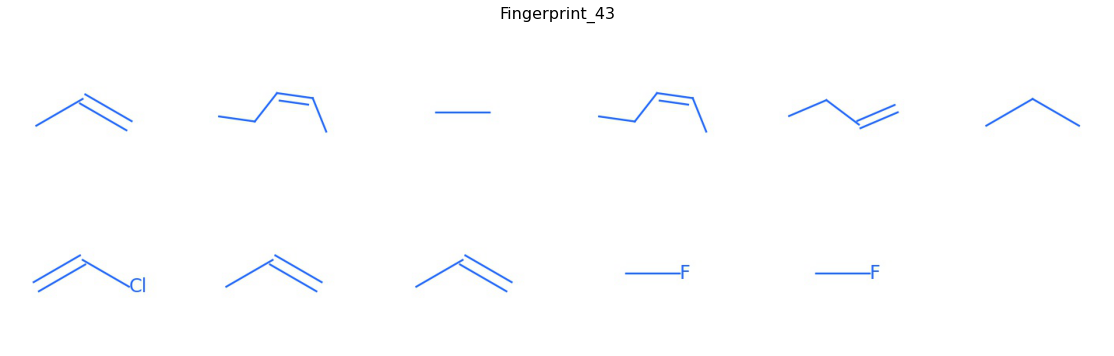

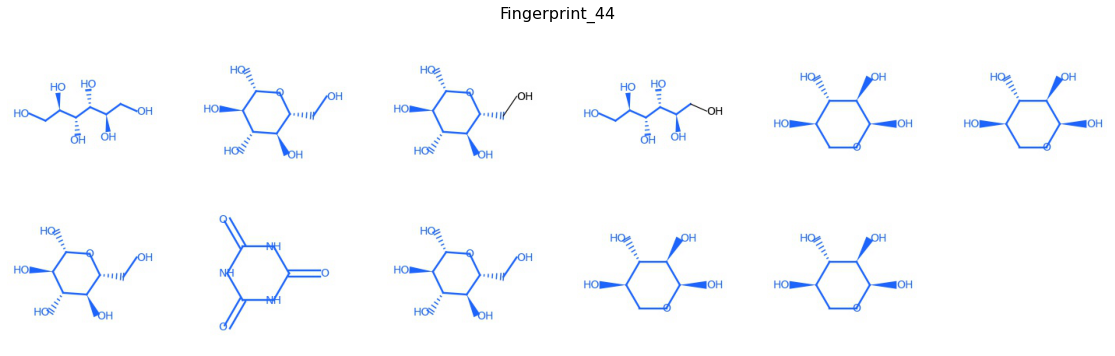

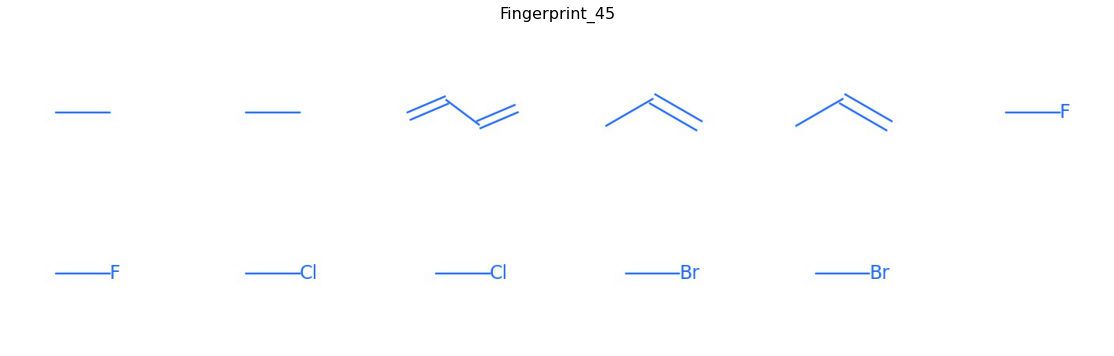

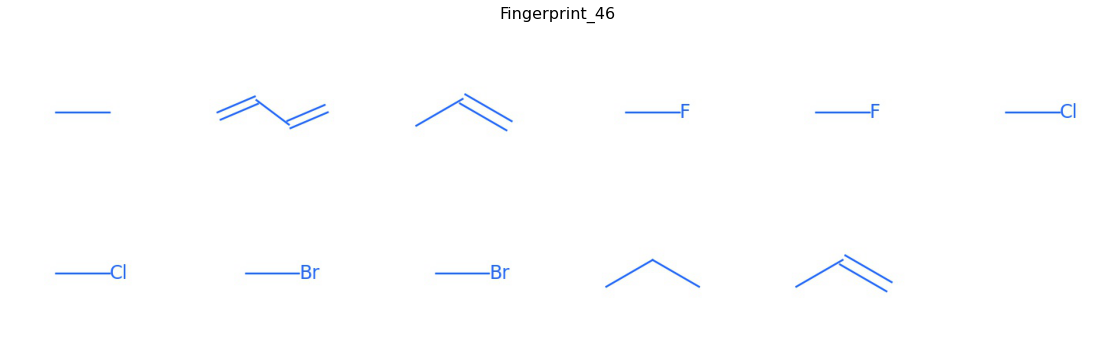

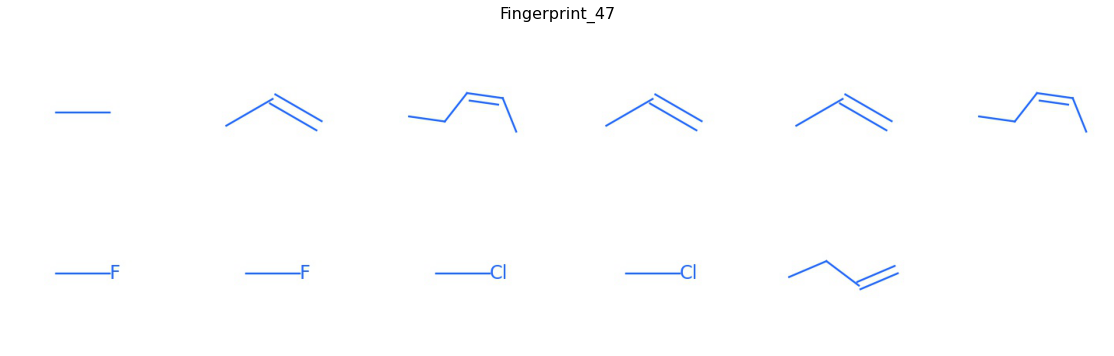

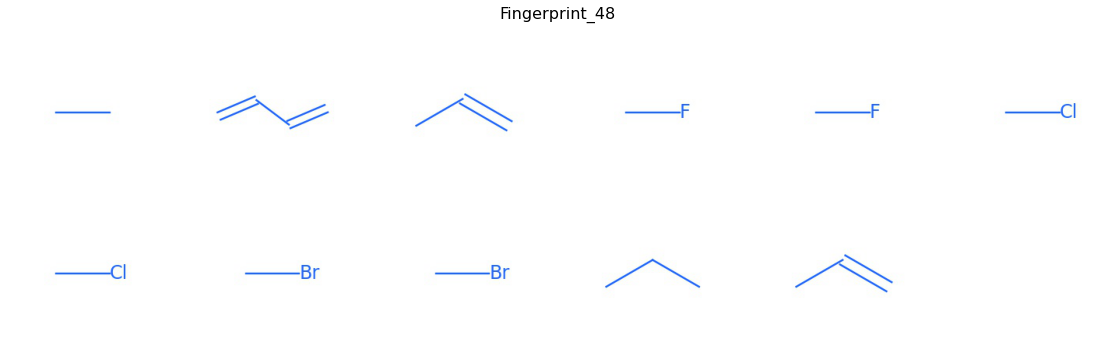

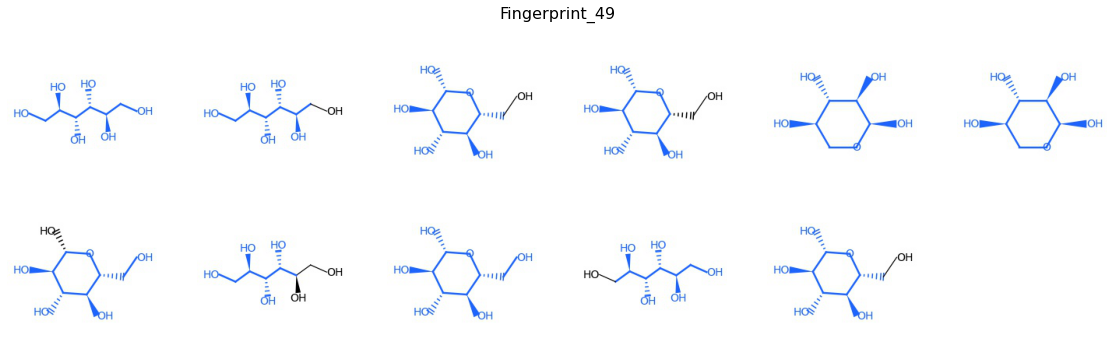

In [57]:
for FP in range(len(dataset)//11):
    visualize(FP)

# Наиболее коррелирующие подструктуры

In [58]:
FPs = []
with open('FP_out.txt', 'r') as f:
    for line in f:
        if line[5] == ' ':
            print(line[:5], '', line[5:], end='')
        else:
            print(line[:6], line[6:], end='')
        FPs.append(line[:-1])
        
top3_pos = FPs[:3]  
top3_neg = FPs[49:46:-1] 

FP_37:  0.08800264603823578
FP_24:  0.0820142739827112
FP_6:   0.08131979039062051
FP_18:  0.07935324012607578
FP_39:  0.07746856958071718
FP_29:  0.07647498778633381
FP_43:  0.07366327073705294
FP_15:  0.07228113847459024
FP_25:  0.07212630177583881
FP_31:  0.07196204877092699
FP_13:  0.07171294616600693
FP_26:  0.07007955860357558
FP_16:  0.06999366427290123
FP_47:  0.06995233862314071
FP_5:   0.06923442128917108
FP_19:  0.06825444039911974
FP_14:  0.06758315105153587
FP_32:  0.06629722468076826
FP_20:  0.0662024634333865
FP_17:  0.0630896382916145
FP_33:  0.063076930314714
FP_36:  0.06190043317108049
FP_46:  0.06109924420102945
FP_0:   0.06014475220210153
FP_30:  0.05929572025073387
FP_38:  0.058687284700267586
FP_48:  0.05814672756749834
FP_35:  0.057940031456537915
FP_8:   0.057772810648336725
FP_45:  0.05656355889124489
FP_4:   -0.07548255025428308
FP_7:   -0.09619023839355499
FP_40:  -0.10325452463888363
FP_42:  -0.10691296753042995
FP_28:  -0.10740493615749347
FP_12:  -0.110683

# Положительная корреляция (top 3)

In [59]:
def index(top3):
    ids = []
    for i in top3:
        i = int(i[3:4]) if i[4] ==":" else int(i[3:5])
        ids.append(i)
    return ids

In [60]:
top3_pos

['FP_37: 0.08800264603823578',
 'FP_24: 0.0820142739827112',
 'FP_6: 0.08131979039062051']

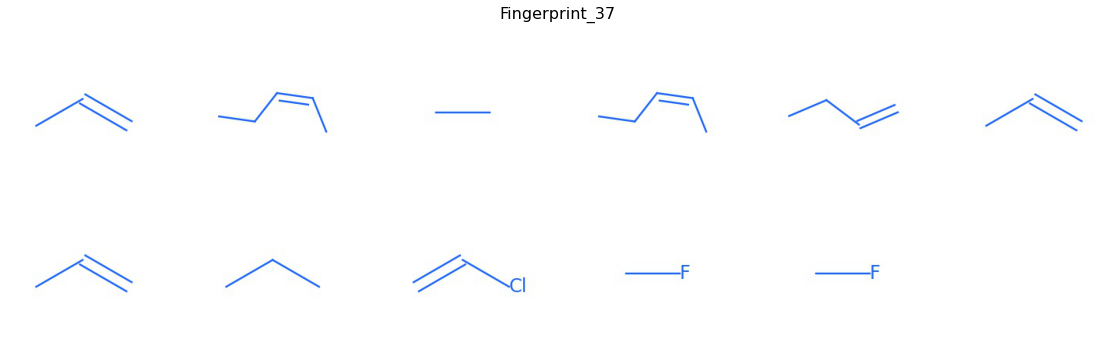

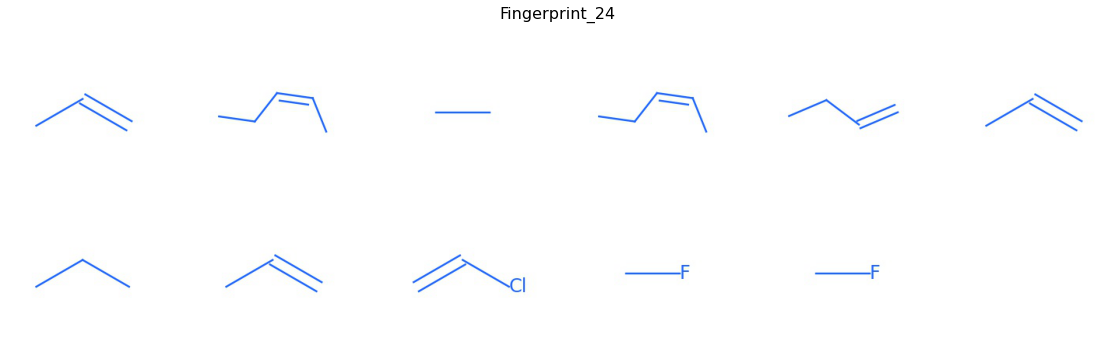

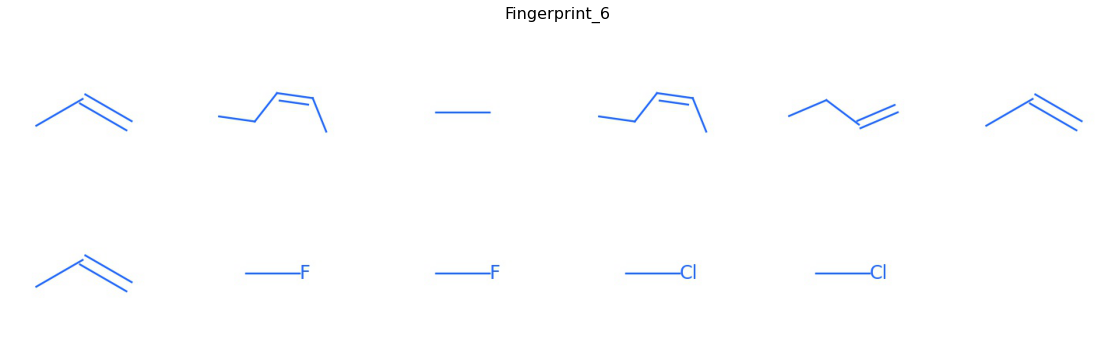

In [61]:
for i in index(top3_pos):
    visualize(i)

# Отрицательная корреляция (top3)

In [62]:
top3_neg

['FP_41: -0.13431966437086817',
 'FP_22: -0.12152890450494158',
 'FP_11: -0.12049389383033905']

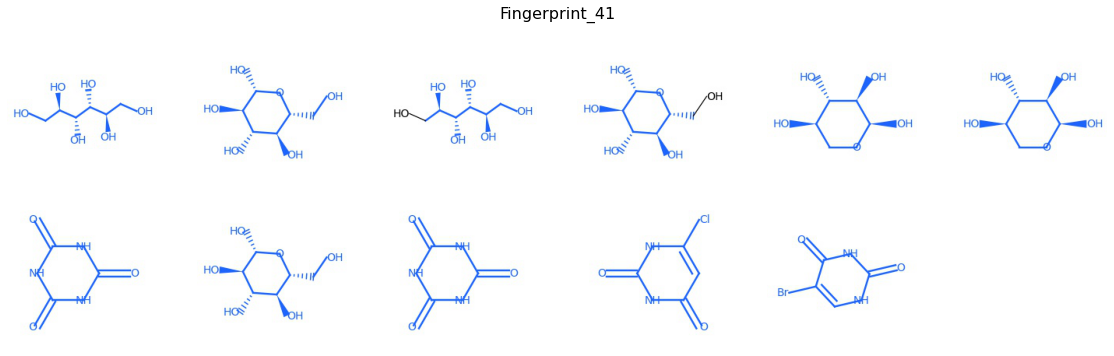

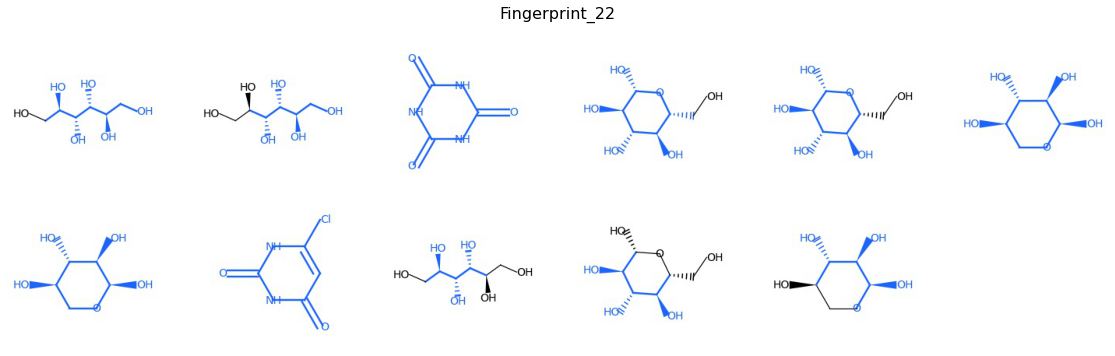

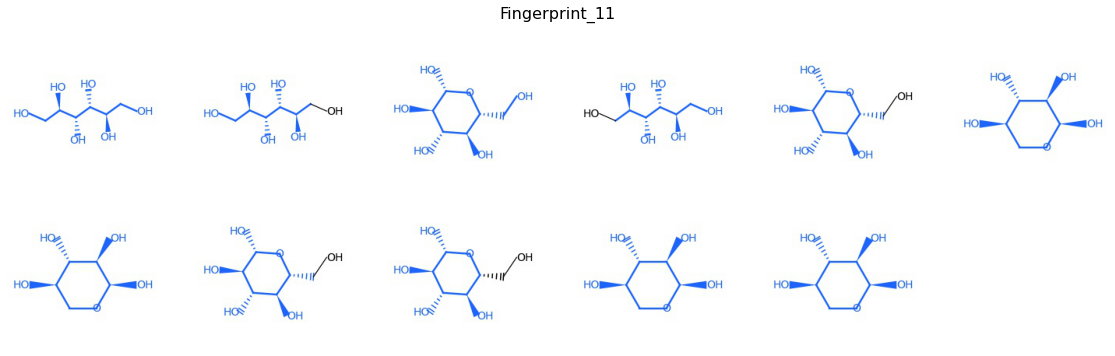

In [63]:
for i in index(top3_neg):
    visualize(i)